# Step 1: Import libraries


In [29]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.impute import KNNImputer
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

In [30]:
# Display setup
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set(style='whitegrid')


#  Step 2: Load Data

In [31]:
df = pd.read_csv('real_estate_data.csv')

print(" Initial Shape:", df.shape)
display(df.head())

# Create a backup
df_original = df.copy()


 Initial Shape: (306, 26)


,property_id,listing_date,sale_date,city,latitude,longitude,property_type,bedrooms,bathrooms,area,lot_size,year_built,age,condition,price,parking,has_pool,has_fireplace,stories,garage_spaces,hoa_fee,days_on_market,views,school_rating,walk_score,description
0,PROP_0183,2023-12-05,2023-12-11,San Antonio,29.428,-98.391,Townhouse,3,1.500,548.000,0.417,1978.000,46.000,Fair,273130.000,Garage,True,Yes,2,2,182.210,20.000,130,5,65.600,Spacious 3 bedroom townhouse. Perfect for fami...
1,PROP_0155,2021-06-24,2021-09-12,Chicago,41.718,-87.573,Single Family,4,2.000,2442.000,0.111,1940.000,84.000,Excellent,606353.000,Garage,False,Yes,3,1,148.800,14.000,129,4,76.200,NaN
2,PROP_0112,2020-10-15,2021-02-12,San Antonio,29.515,-98.585,Townhouse,3,2.500,1435.000,0.238,2007.000,18.000,Good,489019.000,Garage,False,No,1,2,185.350,51.000,121,6,NaN,Beautiful good townhouse with 3 bedrooms in Sa...
3,PROP_0204,2021-10-03,2022-02-25,New York,40.643,-74.010,Condo,3,1.500,898.000,NaN,2012.000,12.000,Fair,525116.000,Garage,True,Yes,1,2,205.670,80.000,136,1,73.000,Charming condo featuring 1.5 bathrooms. Great ...
4,PROP_0061,2020-04-01,2020-07-18,Houston,29.741,-95.339,Single Family,6,2.000,3312.000,0.265,2010.000,15.000,Poor,796409.000,Garage,True,Yes,2,1,NaN,51.000,118,6,68.400,Charming single family featuring 2.0 bathrooms...


#  Step 3: Initial Exploration


In [32]:
print(df.info())
print(df.describe(include='all'))

# Missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Duplicates
print("\nDuplicates:", df.duplicated().sum())

# Unique values
print("\nUnique values summary:")
print(df.nunique())

def data_quality_report(df):
    report = pd.DataFrame({
        'dtype': df.dtypes,
        'missing': df.isnull().sum(),
        'missing_pct': (df.isnull().sum() / len(df)) * 100,
        'unique': df.nunique(),
        'unique_pct': (df.nunique() / len(df)) * 100
    })
    return report

print("\n📊 Data Quality Report:")
print(data_quality_report(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   property_id     306 non-null    object 
 1   listing_date    306 non-null    object 
 2   sale_date       306 non-null    object 
 3   city            306 non-null    object 
 4   latitude        306 non-null    float64
 5   longitude       306 non-null    float64
 6   property_type   306 non-null    object 
 7   bedrooms        306 non-null    int64  
 8   bathrooms       306 non-null    float64
 9   area            306 non-null    float64
 10  lot_size        222 non-null    float64
 11  year_built      293 non-null    float64
 12  age             306 non-null    float64
 13  condition       306 non-null    object 
 14  price           306 non-null    float64
 15  parking         280 non-null    object 
 16  has_pool        306 non-null    bool   
 17  has_fireplace   306 non-null    obj

Step 4: Advanced Missing Value Handling

In [33]:
# Strategy 1: Drop columns with too many missing values
threshold = 0.5
df = df[df.columns[df.isnull().mean() < threshold]]

# Strategy 2: Identify missing patterns
def missing_patterns(df):
    missing_cols = df.columns[df.isnull().any()].tolist()
    if missing_cols:
        print("\n🔍 Missing Value Patterns:")
        for col in missing_cols:
            print(f"{col}: {df[col].isnull().sum()} missing")

missing_patterns(df)

# Strategy 3: Advanced imputation
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

# KNN Imputation for numeric columns
if len(num_cols) > 0 and df[num_cols].isnull().any().any():
    knn_imputer = KNNImputer(n_neighbors=5)
    df[num_cols] = knn_imputer.fit_transform(df[num_cols])

# Categorical imputation (mode or 'Missing' category)
for col in cat_cols:
    if df[col].isnull().any():
        # Create 'Missing' category instead of dropping
        df[col].fillna('Missing', inplace=True)

# Drop duplicates
df = df.drop_duplicates()
print(f"\n✅ Removed {len(df_original) - len(df)} duplicate rows")



🔍 Missing Value Patterns:
lot_size: 84 missing
year_built: 13 missing
parking: 26 missing
hoa_fee: 49 missing
walk_score: 31 missing
description: 15 missing

✅ Removed 6 duplicate rows


# Step 5: Time-based Features

In [34]:
time_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]

print("\nTime-related columns identified:", time_cols)

for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Basic features
    df[f'{col}_year'] = df[col].dt.year
    df[f'{col}_month'] = df[col].dt.month
    df[f'{col}_day'] = df[col].dt.day
    df[f'{col}_weekday'] = df[col].dt.weekday
    df[f'{col}_hour'] = df[col].dt.hour
    df[f'{col}_quarter'] = df[col].dt.quarter
    
    # Advanced features
    df[f'{col}_is_weekend'] = (df[col].dt.weekday >= 5).astype(int)
    df[f'{col}_is_month_start'] = df[col].dt.is_month_start.astype(int)
    df[f'{col}_is_month_end'] = df[col].dt.is_month_end.astype(int)
    df[f'{col}_day_of_year'] = df[col].dt.dayofyear
    df[f'{col}_week_of_year'] = df[col].dt.isocalendar().week
    
    # Cyclical encoding for periodic features
    df[f'{col}_month_sin'] = np.sin(2 * np.pi * df[col].dt.month / 12)
    df[f'{col}_month_cos'] = np.cos(2 * np.pi * df[col].dt.month / 12)
    df[f'{col}_day_sin'] = np.sin(2 * np.pi * df[col].dt.day / 31)
    df[f'{col}_day_cos'] = np.cos(2 * np.pi * df[col].dt.day / 31)
    df[f'{col}_hour_sin'] = np.sin(2 * np.pi * df[col].dt.hour / 24)
    df[f'{col}_hour_cos'] = np.cos(2 * np.pi * df[col].dt.hour / 24)

# Time differences between dates
if len(time_cols) >= 2:
    df['time_diff_days'] = (df[time_cols[1]] - df[time_cols[0]]).dt.days
    df['time_diff_hours'] = (df[time_cols[1]] - df[time_cols[0]]).dt.total_seconds() / 3600


display(df.head(3))


Time-related columns identified: ['listing_date', 'sale_date']


,property_id,listing_date,sale_date,city,latitude,longitude,property_type,bedrooms,bathrooms,area,lot_size,year_built,age,condition,price,parking,has_pool,has_fireplace,stories,garage_spaces,hoa_fee,days_on_market,views,school_rating,walk_score,description,listing_date_year,listing_date_month,listing_date_day,listing_date_weekday,listing_date_hour,listing_date_quarter,listing_date_is_weekend,listing_date_is_month_start,listing_date_is_month_end,listing_date_day_of_year,listing_date_week_of_year,listing_date_month_sin,listing_date_month_cos,listing_date_day_sin,listing_date_day_cos,listing_date_hour_sin,listing_date_hour_cos,sale_date_year,sale_date_month,sale_date_day,sale_date_weekday,sale_date_hour,sale_date_quarter,sale_date_is_weekend,sale_date_is_month_start,sale_date_is_month_end,sale_date_day_of_year,sale_date_week_of_year,sale_date_month_sin,sale_date_month_cos,sale_date_day_sin,sale_date_day_cos,sale_date_hour_sin,sale_date_hour_cos,time_diff_days,time_diff_hours
0,PROP_0183,2023-12-05,2023-12-11,San Antonio,29.428,-98.391,Townhouse,3.000,1.500,548.000,0.417,1978.000,46.000,Fair,273130.000,Garage,True,Yes,2.000,2.000,182.210,20.000,130.000,5.000,65.600,Spacious 3 bedroom townhouse. Perfect for fami...,2023,12,5,1,0,4,0,0,0,339,49,-0.000,1.000,0.849,0.529,0.000,1.000,2023,12,11,0,0,4,0,0,0,345,50,-0.000,1.000,0.791,-0.612,0.000,1.000,6,144.000
1,PROP_0155,2021-06-24,2021-09-12,Chicago,41.718,-87.573,Single Family,4.000,2.000,2442.000,0.111,1940.000,84.000,Excellent,606353.000,Garage,False,Yes,3.000,1.000,148.800,14.000,129.000,4.000,76.200,Missing,2021,6,24,3,0,2,0,0,0,175,25,0.000,-1.000,-0.988,0.151,0.000,1.000,2021,9,12,6,0,3,1,0,0,255,36,-1.000,-0.000,0.651,-0.759,0.000,1.000,80,1920.000
2,PROP_0112,2020-10-15,2021-02-12,San Antonio,29.515,-98.585,Townhouse,3.000,2.500,1435.000,0.238,2007.000,18.000,Good,489019.000,Garage,False,No,1.000,2.000,185.350,51.000,121.000,6.000,70.220,Beautiful good townhouse with 3 bedrooms in Sa...,2020,10,15,3,0,4,0,0,0,289,42,-0.866,0.500,0.101,-0.995,0.000,1.000,2021,2,12,4,0,1,0,0,0,43,6,0.866,0.500,0.651,-0.759,0.000,1.000,120,2880.000


#  Step 6: Geo Features

In [35]:


if {'latitude', 'longitude'}.issubset(df.columns):
    # Regional mapping
    def latlon_to_region(lat, lon):
        if pd.isna(lat) or pd.isna(lon):
            return 'Unknown'
        if lat > 0 and lon > 0:
            return 'NE'
        elif lat > 0 and lon < 0:
            return 'NW'
        elif lat < 0 and lon > 0:
            return 'SE'
        else:
            return 'SW'
    df['geo_region'] = df.apply(lambda x: latlon_to_region(x['latitude'], x['longitude']), axis=1)
    
    # Haversine distance
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371
        phi1, phi2 = np.radians(lat1), np.radians(lat2)
        dphi = np.radians(lat2 - lat1)
        dlambda = np.radians(lon2 - lon1)
        a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
        return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Distance from major cities
    df['dist_from_NYC_km'] = haversine(df['latitude'], df['longitude'], 40.7128, -74.0060)
    df['dist_from_LA_km'] = haversine(df['latitude'], df['longitude'], 34.0522, -118.2437)
    df['dist_from_Chicago_km'] = haversine(df['latitude'], df['longitude'], 41.8781, -87.6298)
    
    # Distance from center of dataset
    center_lat = df['latitude'].median()
    center_lon = df['longitude'].median()
    df['dist_from_center_km'] = haversine(df['latitude'], df['longitude'], center_lat, center_lon)
    
    # Lat/Lon clustering (binning)
    df['lat_bin'] = pd.cut(df['latitude'], bins=10, labels=False)
    df['lon_bin'] = pd.cut(df['longitude'], bins=10, labels=False)


    display(df.head(3))


,property_id,listing_date,sale_date,city,latitude,longitude,property_type,bedrooms,bathrooms,area,lot_size,year_built,age,condition,price,parking,has_pool,has_fireplace,stories,garage_spaces,hoa_fee,days_on_market,views,school_rating,walk_score,description,listing_date_year,listing_date_month,listing_date_day,listing_date_weekday,listing_date_hour,listing_date_quarter,listing_date_is_weekend,listing_date_is_month_start,listing_date_is_month_end,listing_date_day_of_year,listing_date_week_of_year,listing_date_month_sin,listing_date_month_cos,listing_date_day_sin,listing_date_day_cos,listing_date_hour_sin,listing_date_hour_cos,sale_date_year,sale_date_month,sale_date_day,sale_date_weekday,sale_date_hour,sale_date_quarter,sale_date_is_weekend,sale_date_is_month_start,sale_date_is_month_end,sale_date_day_of_year,sale_date_week_of_year,sale_date_month_sin,sale_date_month_cos,sale_date_day_sin,sale_date_day_cos,sale_date_hour_sin,sale_date_hour_cos,time_diff_days,time_diff_hours,geo_region,dist_from_NYC_km,dist_from_LA_km,dist_from_Chicago_km,dist_from_center_km,lat_bin,lon_bin
0,PROP_0183,2023-12-05,2023-12-11,San Antonio,29.428,-98.391,Townhouse,3.000,1.500,548.000,0.417,1978.000,46.000,Fair,273130.000,Garage,True,Yes,2.000,2.000,182.210,20.000,130.000,5.000,65.600,Spacious 3 bedroom townhouse. Perfect for fami...,2023,12,5,1,0,4,0,0,0,339,49,-0.000,1.000,0.849,0.529,0.000,1.000,2023,12,11,0,0,4,0,0,0,345,50,-0.000,1.000,0.791,-0.612,0.000,1.000,6,144.000,NW,2536.673,1942.948,1688.566,468.577,0,4
1,PROP_0155,2021-06-24,2021-09-12,Chicago,41.718,-87.573,Single Family,4.000,2.000,2442.000,0.111,1940.000,84.000,Excellent,606353.000,Garage,False,Yes,3.000,1.000,148.800,14.000,129.000,4.000,76.200,Missing,2021,6,24,3,0,2,0,0,0,175,25,0.000,-1.000,-0.988,0.151,0.000,1.000,2021,9,12,6,0,3,1,0,0,255,36,-1.000,-0.000,0.651,-0.759,0.000,1.000,80,1920.000,NW,1139.107,2806.220,18.462,1230.753,9,6
2,PROP_0112,2020-10-15,2021-02-12,San Antonio,29.515,-98.585,Townhouse,3.000,2.500,1435.000,0.238,2007.000,18.000,Good,489019.000,Garage,False,No,1.000,2.000,185.350,51.000,121.000,6.000,70.220,Beautiful good townhouse with 3 bedrooms in Sa...,2020,10,15,3,0,4,0,0,0,289,42,-0.866,0.500,0.101,-0.995,0.000,1.000,2021,2,12,4,0,1,0,0,0,43,6,0.866,0.500,0.651,-0.759,0.000,1.000,120,2880.000,NW,2546.238,1921.920,1690.498,465.519,0,4


# Step 7: Text Processing

In [36]:
text_cols = df.select_dtypes(include='object').columns

def clean_text(x):
    if isinstance(x, str):
        x = x.lower().strip()
        x = re.sub(r'[^a-z0-9\s]', '', x)
        x = re.sub(r'\s+', ' ', x)
    return x

# Text feature extraction
def text_features(df, col):
    df[f'{col}_length'] = df[col].astype(str).str.len()
    df[f'{col}_word_count'] = df[col].astype(str).str.split().str.len()
    df[f'{col}_unique_words'] = df[col].astype(str).apply(lambda x: len(set(x.split())))
    df[f'{col}_avg_word_length'] = df[col].astype(str).apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
    df[f'{col}_has_numbers'] = df[col].astype(str).str.contains(r'\d').astype(int)
    df[f'{col}_has_special'] = df[col].astype(str).str.contains(r'[^a-zA-Z0-9\s]').astype(int)
    return df

for col in text_cols:
    df[col] = df[col].apply(clean_text)
    if df[col].dtype == 'object':
        df = text_features(df, col)

display(df.head(3))

,property_id,listing_date,sale_date,city,latitude,longitude,property_type,bedrooms,bathrooms,area,lot_size,year_built,age,condition,price,parking,has_pool,has_fireplace,stories,garage_spaces,hoa_fee,days_on_market,views,school_rating,walk_score,description,listing_date_year,listing_date_month,listing_date_day,listing_date_weekday,listing_date_hour,listing_date_quarter,listing_date_is_weekend,listing_date_is_month_start,listing_date_is_month_end,listing_date_day_of_year,listing_date_week_of_year,listing_date_month_sin,listing_date_month_cos,listing_date_day_sin,listing_date_day_cos,listing_date_hour_sin,listing_date_hour_cos,sale_date_year,sale_date_month,sale_date_day,sale_date_weekday,sale_date_hour,sale_date_quarter,sale_date_is_weekend,sale_date_is_month_start,sale_date_is_month_end,sale_date_day_of_year,sale_date_week_of_year,sale_date_month_sin,sale_date_month_cos,sale_date_day_sin,sale_date_day_cos,sale_date_hour_sin,sale_date_hour_cos,time_diff_days,time_diff_hours,geo_region,dist_from_NYC_km,dist_from_LA_km,dist_from_Chicago_km,dist_from_center_km,lat_bin,lon_bin,property_id_length,property_id_word_count,property_id_unique_words,property_id_avg_word_length,property_id_has_numbers,property_id_has_special,city_length,city_word_count,city_unique_words,city_avg_word_length,city_has_numbers,city_has_special,property_type_length,property_type_word_count,property_type_unique_words,property_type_avg_word_length,property_type_has_numbers,property_type_has_special,condition_length,condition_word_count,condition_unique_words,condition_avg_word_length,condition_has_numbers,condition_has_special,parking_length,parking_word_count,parking_unique_words,parking_avg_word_length,parking_has_numbers,parking_has_special,has_fireplace_length,has_fireplace_word_count,has_fireplace_unique_words,has_fireplace_avg_word_length,has_fireplace_has_numbers,has_fireplace_has_special,description_length,description_word_count,description_unique_words,description_avg_word_length,description_has_numbers,description_has_special,geo_region_length,geo_region_word_count,geo_region_unique_words,geo_region_avg_word_length,geo_region_has_numbers,geo_region_has_special
0,prop0183,2023-12-05,2023-12-11,san antonio,29.428,-98.391,townhouse,3.000,1.500,548.000,0.417,1978.000,46.000,fair,273130.000,garage,True,yes,2.000,2.000,182.210,20.000,130.000,5.000,65.600,spacious 3 bedroom townhouse perfect for famil...,2023,12,5,1,0,4,0,0,0,339,49,-0.000,1.000,0.849,0.529,0.000,1.000,2023,12,11,0,0,4,0,0,0,345,50,-0.000,1.000,0.791,-0.612,0.000,1.000,6,144.000,nw,2536.673,1942.948,1688.566,468.577,0,4,8,1,1,8.000,1,0,11,2,2,5.000,0,0,9,1,1,9.000,0,0,4,1,1,4.000,0,0,6,1,1,6.000,0,0,3,1,1,3.000,0,0,101,14,14,6.286,1,0,2,1,1,2.000,0,0
1,prop0155,2021-06-24,2021-09-12,chicago,41.718,-87.573,single family,4.000,2.000,2442.000,0.111,1940.000,84.000,excellent,606353.000,garage,False,yes,3.000,1.000,148.800,14.000,129.000,4.000,76.200,missing,2021,6,24,3,0,2,0,0,0,175,25,0.000,-1.000,-0.988,0.151,0.000,1.000,2021,9,12,6,0,3,1,0,0,255,36,-1.000,-0.000,0.651,-0.759,0.000,1.000,80,1920.000,nw,1139.107,2806.220,18.462,1230.753,9,6,8,1,1,8.000,1,0,7,1,1,7.000,0,0,13,2,2,6.000,0,0,9,1,1,9.000,0,0,6,1,1,6.000,0,0,3,1,1,3.000,0,0,7,1,1,7.000,0,0,2,1,1,2.000,0,0
2,prop0112,2020-10-15,2021-02-12,san antonio,29.515,-98.585,townhouse,3.000,2.500,1435.000,0.238,2007.000,18.000,good,489019.000,garage,False,no,1.000,2.000,185.350,51.000,121.000,6.000,70.220,beautiful good townhouse with 3 bedrooms in sa...,2020,10,15,3,0,4,0,0,0,289,42,-0.866,0.500,0.101,-0.995,0.000,1.000,2021,2,12,4,0,1,0,0,0,43,6,0.866,0.500,0.651,-0.759,0.000,1.000,120,2880.000,nw,2546.238,1921.920,1690.498,465.519,0,4,8,1,1,8.000,1,0,11,2,2,5.000,0,0,9,1,1,9.000,0,0,4,1,1,4.000,0,0,6,1,1,6.000,0,0,2,1,1,2.000,0,0,107,16,16,5.750,1,0,2,1,1,2.000,0,0


# Step 8: Statistical Feature Engineering

In [37]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()

# Skewness and Kurtosis features
for col in num_cols:
    if df[col].std() != 0:
        df[f'{col}_log'] = np.log1p(df[col] - df[col].min() + 1)
        df[f'{col}_sqrt'] = np.sqrt(df[col] - df[col].min() + 1)
        df[f'{col}_squared'] = df[col] ** 2

# Rolling statistics (if data has sequential nature)
if 'id' in df.columns or df.index.is_monotonic_increasing:
    for col in num_cols[:3]:  # Limit to avoid explosion
        df[f'{col}_rolling_mean_3'] = df[col].rolling(window=3, min_periods=1).mean()
        df[f'{col}_rolling_std_3'] = df[col].rolling(window=3, min_periods=1).std()
        df[f'{col}_lag_1'] = df[col].shift(1)
        df[f'{col}_lag_2'] = df[col].shift(2)

# Percentile features
for col in num_cols[:5]:  # Limit computation
    df[f'{col}_percentile'] = df[col].rank(pct=True)

display(df.head(4))

,property_id,listing_date,sale_date,city,latitude,longitude,property_type,bedrooms,bathrooms,area,lot_size,year_built,age,condition,price,parking,has_pool,has_fireplace,stories,garage_spaces,hoa_fee,days_on_market,views,school_rating,walk_score,description,listing_date_year,listing_date_month,listing_date_day,listing_date_weekday,listing_date_hour,listing_date_quarter,listing_date_is_weekend,listing_date_is_month_start,listing_date_is_month_end,listing_date_day_of_year,listing_date_week_of_year,listing_date_month_sin,listing_date_month_cos,listing_date_day_sin,listing_date_day_cos,listing_date_hour_sin,listing_date_hour_cos,sale_date_year,sale_date_month,sale_date_day,sale_date_weekday,sale_date_hour,sale_date_quarter,sale_date_is_weekend,sale_date_is_month_start,sale_date_is_month_end,sale_date_day_of_year,sale_date_week_of_year,sale_date_month_sin,sale_date_month_cos,sale_date_day_sin,sale_date_day_cos,sale_date_hour_sin,sale_date_hour_cos,time_diff_days,time_diff_hours,geo_region,dist_from_NYC_km,dist_from_LA_km,dist_from_Chicago_km,dist_from_center_km,lat_bin,lon_bin,property_id_length,property_id_word_count,property_id_unique_words,property_id_avg_word_length,property_id_has_numbers,property_id_has_special,city_length,city_word_count,city_unique_words,city_avg_word_length,city_has_numbers,city_has_special,property_type_length,property_type_word_count,property_type_unique_words,property_type_avg_word_length,property_type_has_numbers,property_type_has_special,condition_length,condition_word_count,condition_unique_words,condition_avg_word_length,condition_has_numbers,condition_has_special,parking_length,parking_word_count,parking_unique_words,parking_avg_word_length,parking_has_numbers,parking_has_special,has_fireplace_length,has_fireplace_word_count,has_fireplace_unique_words,has_fireplace_avg_word_length,has_fireplace_has_numbers,has_fireplace_has_special,description_length,description_word_count,description_unique_words,description_avg_word_length,description_has_numbers,description_has_special,geo_region_length,geo_region_word_count,geo_region_unique_words,geo_region_avg_word_length,geo_region_has_numbers,geo_region_has_special,latitude_log,latitude_sqrt,latitude_squared,longitude_log,longitude_sqrt,longitude_squared,bedrooms_log,bedrooms_sqrt,bedrooms_squared,bathrooms_log,bathrooms_sqrt,bathrooms_squared,area_log,area_sqrt,area_squared,lot_size_log,lot_size_sqrt,lot_size_squared,year_built_log,year_built_sqrt,year_built_squared,age_log,age_sqrt,age_squared,price_log,price_sqrt,price_squared,stories_log,stories_sqrt,stories_squared,garage_spaces_log,garage_spaces_sqrt,garage_spaces_squared,hoa_fee_log,hoa_fee_sqrt,hoa_fee_squared,days_on_market_log,days_on_market_sqrt,days_on_market_squared,views_log,views_sqrt,views_squared,school_rating_log,school_rating_sqrt,school_rating_squared,walk_score_log,walk_score_sqrt,walk_score_squared,listing_date_year_log,listing_date_year_sqrt,listing_date_year_squared,listing_date_month_log,listing_date_month_sqrt,listing_date_month_squared,listing_date_day_log,listing_date_day_sqrt,listing_date_day_squared,listing_date_weekday_log,listing_date_weekday_sqrt,listing_date_weekday_squared,listing_date_quarter_log,listing_date_quarter_sqrt,listing_date_quarter_squared,listing_date_is_weekend_log,listing_date_is_weekend_sqrt,listing_date_is_weekend_squared,listing_date_is_month_start_log,listing_date_is_month_start_sqrt,listing_date_is_month_start_squared,listing_date_is_month_end_log,listing_date_is_month_end_sqrt,listing_date_is_month_end_squared,listing_date_day_of_year_log,listing_date_day_of_year_sqrt,listing_date_day_of_year_squared,listing_date_week_of_year_log,listing_date_week_of_year_sqrt,listing_date_week_of_year_squared,listing_date_month_sin_log,listing_date_month_sin_sqrt,listing_date_month_sin_squared,listing_date_month_cos_log,listing_date_month_cos_sqrt,listing_date_month_cos_squared,listing_date_day_sin_log,listing_date_day_sin_sqrt,listing_date_day_sin_squared,listing_date

# Step 9: Encoding for modelling

In [38]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Frequency encoding
def frequency_encoding(df, col):
    freq = df[col].value_counts(normalize=True)
    df[f'{col}_freq'] = df[col].map(freq)
    return df

# Target encoding (if you have a target variable)
def target_encoding(df, col, target):
    if target in df.columns:
        target_mean = df.groupby(col)[target].mean()
        df[f'{col}_target_enc'] = df[col].map(target_mean)
    return df

for col in cat_cols:
    if df[col].nunique() < 100:  # Avoid high cardinality
        df = frequency_encoding(df, col)
        
        # Label encoding for low cardinality
        if df[col].nunique() <= 10:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
        else:
            # One-hot encoding
            df = pd.get_dummies(df, columns=[col], drop_first=True)

display(df.head(4))

,property_id,listing_date,sale_date,city,latitude,longitude,property_type,bedrooms,bathrooms,area,lot_size,year_built,age,condition,price,parking,has_pool,has_fireplace,stories,garage_spaces,hoa_fee,days_on_market,views,school_rating,walk_score,description,listing_date_year,listing_date_month,listing_date_day,listing_date_weekday,listing_date_hour,listing_date_quarter,listing_date_is_weekend,listing_date_is_month_start,listing_date_is_month_end,listing_date_day_of_year,listing_date_week_of_year,listing_date_month_sin,listing_date_month_cos,listing_date_day_sin,listing_date_day_cos,listing_date_hour_sin,listing_date_hour_cos,sale_date_year,sale_date_month,sale_date_day,sale_date_weekday,sale_date_hour,sale_date_quarter,sale_date_is_weekend,sale_date_is_month_start,sale_date_is_month_end,sale_date_day_of_year,sale_date_week_of_year,sale_date_month_sin,sale_date_month_cos,sale_date_day_sin,sale_date_day_cos,sale_date_hour_sin,sale_date_hour_cos,time_diff_days,time_diff_hours,geo_region,dist_from_NYC_km,dist_from_LA_km,dist_from_Chicago_km,dist_from_center_km,lat_bin,lon_bin,property_id_length,property_id_word_count,property_id_unique_words,property_id_avg_word_length,property_id_has_numbers,property_id_has_special,city_length,city_word_count,city_unique_words,city_avg_word_length,city_has_numbers,city_has_special,property_type_length,property_type_word_count,property_type_unique_words,property_type_avg_word_length,property_type_has_numbers,property_type_has_special,condition_length,condition_word_count,condition_unique_words,condition_avg_word_length,condition_has_numbers,condition_has_special,parking_length,parking_word_count,parking_unique_words,parking_avg_word_length,parking_has_numbers,parking_has_special,has_fireplace_length,has_fireplace_word_count,has_fireplace_unique_words,has_fireplace_avg_word_length,has_fireplace_has_numbers,has_fireplace_has_special,description_length,description_word_count,description_unique_words,description_avg_word_length,description_has_numbers,description_has_special,geo_region_length,geo_region_word_count,geo_region_unique_words,geo_region_avg_word_length,geo_region_has_numbers,geo_region_has_special,latitude_log,latitude_sqrt,latitude_squared,longitude_log,longitude_sqrt,longitude_squared,bedrooms_log,bedrooms_sqrt,bedrooms_squared,bathrooms_log,bathrooms_sqrt,bathrooms_squared,area_log,area_sqrt,area_squared,lot_size_log,lot_size_sqrt,lot_size_squared,year_built_log,year_built_sqrt,year_built_squared,age_log,age_sqrt,age_squared,price_log,price_sqrt,price_squared,stories_log,stories_sqrt,stories_squared,garage_spaces_log,garage_spaces_sqrt,garage_spaces_squared,hoa_fee_log,hoa_fee_sqrt,hoa_fee_squared,days_on_market_log,days_on_market_sqrt,days_on_market_squared,views_log,views_sqrt,views_squared,school_rating_log,school_rating_sqrt,school_rating_squared,walk_score_log,walk_score_sqrt,walk_score_squared,listing_date_year_log,listing_date_year_sqrt,listing_date_year_squared,listing_date_month_log,listing_date_month_sqrt,listing_date_month_squared,listing_date_day_log,listing_date_day_sqrt,listing_date_day_squared,listing_date_weekday_log,listing_date_weekday_sqrt,listing_date_weekday_squared,listing_date_quarter_log,listing_date_quarter_sqrt,listing_date_quarter_squared,listing_date_is_weekend_log,listing_date_is_weekend_sqrt,listing_date_is_weekend_squared,listing_date_is_month_start_log,listing_date_is_month_start_sqrt,listing_date_is_month_start_squared,listing_date_is_month_end_log,listing_date_is_month_end_sqrt,listing_date_is_month_end_squared,listing_date_day_of_year_log,listing_date_day_of_year_sqrt,listing_date_day_of_year_squared,listing_date_week_of_year_log,listing_date_week_of_year_sqrt,listing_date_week_of_year_squared,listing_date_month_sin_log,listing_date_month_sin_sqrt,listing_date_month_sin_squared,listing_date_month_cos_log,listing_date_month_cos_sqrt,listing_date_month_cos_squared,listing_date_day_sin_log,listing_date_day_sin_sqrt,listing_date_day_sin_squared,listing_date

# Step 10: Handle Skewed Features

In [39]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()

# Detect skewed features
skewed_features = []
for col in num_cols:
    if abs(skew(df[col].dropna())) > 0.75:
        skewed_features.append(col)

print(f"\n📈 Found {len(skewed_features)} skewed features")

# Apply transformations
pt = PowerTransformer(method='yeo-johnson')
if skewed_features:
    df[skewed_features] = pt.fit_transform(df[skewed_features])

display(df.head(4))


📈 Found 109 skewed features


,property_id,listing_date,sale_date,city,latitude,longitude,property_type,bedrooms,bathrooms,area,lot_size,year_built,age,condition,price,parking,has_pool,has_fireplace,stories,garage_spaces,hoa_fee,days_on_market,views,school_rating,walk_score,description,listing_date_year,listing_date_month,listing_date_day,listing_date_weekday,listing_date_hour,listing_date_quarter,listing_date_is_weekend,listing_date_is_month_start,listing_date_is_month_end,listing_date_day_of_year,listing_date_week_of_year,listing_date_month_sin,listing_date_month_cos,listing_date_day_sin,listing_date_day_cos,listing_date_hour_sin,listing_date_hour_cos,sale_date_year,sale_date_month,sale_date_day,sale_date_weekday,sale_date_hour,sale_date_quarter,sale_date_is_weekend,sale_date_is_month_start,sale_date_is_month_end,sale_date_day_of_year,sale_date_week_of_year,sale_date_month_sin,sale_date_month_cos,sale_date_day_sin,sale_date_day_cos,sale_date_hour_sin,sale_date_hour_cos,time_diff_days,time_diff_hours,geo_region,dist_from_NYC_km,dist_from_LA_km,dist_from_Chicago_km,dist_from_center_km,lat_bin,lon_bin,property_id_length,property_id_word_count,property_id_unique_words,property_id_avg_word_length,property_id_has_numbers,property_id_has_special,city_length,city_word_count,city_unique_words,city_avg_word_length,city_has_numbers,city_has_special,property_type_length,property_type_word_count,property_type_unique_words,property_type_avg_word_length,property_type_has_numbers,property_type_has_special,condition_length,condition_word_count,condition_unique_words,condition_avg_word_length,condition_has_numbers,condition_has_special,parking_length,parking_word_count,parking_unique_words,parking_avg_word_length,parking_has_numbers,parking_has_special,has_fireplace_length,has_fireplace_word_count,has_fireplace_unique_words,has_fireplace_avg_word_length,has_fireplace_has_numbers,has_fireplace_has_special,description_length,description_word_count,description_unique_words,description_avg_word_length,description_has_numbers,description_has_special,geo_region_length,geo_region_word_count,geo_region_unique_words,geo_region_avg_word_length,geo_region_has_numbers,geo_region_has_special,latitude_log,latitude_sqrt,latitude_squared,longitude_log,longitude_sqrt,longitude_squared,bedrooms_log,bedrooms_sqrt,bedrooms_squared,bathrooms_log,bathrooms_sqrt,bathrooms_squared,area_log,area_sqrt,area_squared,lot_size_log,lot_size_sqrt,lot_size_squared,year_built_log,year_built_sqrt,year_built_squared,age_log,age_sqrt,age_squared,price_log,price_sqrt,price_squared,stories_log,stories_sqrt,stories_squared,garage_spaces_log,garage_spaces_sqrt,garage_spaces_squared,hoa_fee_log,hoa_fee_sqrt,hoa_fee_squared,days_on_market_log,days_on_market_sqrt,days_on_market_squared,views_log,views_sqrt,views_squared,school_rating_log,school_rating_sqrt,school_rating_squared,walk_score_log,walk_score_sqrt,walk_score_squared,listing_date_year_log,listing_date_year_sqrt,listing_date_year_squared,listing_date_month_log,listing_date_month_sqrt,listing_date_month_squared,listing_date_day_log,listing_date_day_sqrt,listing_date_day_squared,listing_date_weekday_log,listing_date_weekday_sqrt,listing_date_weekday_squared,listing_date_quarter_log,listing_date_quarter_sqrt,listing_date_quarter_squared,listing_date_is_weekend_log,listing_date_is_weekend_sqrt,listing_date_is_weekend_squared,listing_date_is_month_start_log,listing_date_is_month_start_sqrt,listing_date_is_month_start_squared,listing_date_is_month_end_log,listing_date_is_month_end_sqrt,listing_date_is_month_end_squared,listing_date_day_of_year_log,listing_date_day_of_year_sqrt,listing_date_day_of_year_squared,listing_date_week_of_year_log,listing_date_week_of_year_sqrt,listing_date_week_of_year_squared,listing_date_month_sin_log,listing_date_month_sin_sqrt,listing_date_month_sin_squared,listing_date_month_cos_log,listing_date_month_cos_sqrt,listing_date_month_cos_squared,listing_date_day_sin_log,listing_date_day_sin_sqrt,listing_date_day_sin_squared,listing_date

# Step 11: Advanced Scaling

In [40]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()

# RobustScaler (better for outliers)
scaler = RobustScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Alternative scalers:
# StandardScaler - for normal distribution
# MinMaxScaler - for bounded range [0,1]
# MaxAbsScaler - for sparse data

# ======================================================
# 🚫 Step 13: Advanced Outlier Detection
# ======================================================
# Method 1: IQR method
def remove_outliers_iqr(df, cols, factor=1.5):
    df_clean = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

# Method 2: Z-score method
def remove_outliers_zscore(df, cols, threshold=3):
    df_clean = df.copy()
    for col in cols:
        z_scores = np.abs(stats.zscore(df[col]))
        df_clean = df_clean[z_scores < threshold]
    return df_clean

# Choose method based on your needs
# df = remove_outliers_iqr(df, num_cols)
# df = remove_outliers_zscore(df, num_cols)

# Method 3: Isolation Forest (uncomment to use)
# from sklearn.ensemble import IsolationForest
# iso = IsolationForest(contamination=0.1, random_state=42)
# outliers = iso.fit_predict(df[num_cols])
# df = df[outliers == 1]

print(f"\n✅ Data shape after outlier removal: {df.shape}")

display(df.head(4))




✅ Data shape after outlier removal: (300, 353)


,property_id,listing_date,sale_date,city,latitude,longitude,property_type,bedrooms,bathrooms,area,lot_size,year_built,age,condition,price,parking,has_pool,has_fireplace,stories,garage_spaces,hoa_fee,days_on_market,views,school_rating,walk_score,description,listing_date_year,listing_date_month,listing_date_day,listing_date_weekday,listing_date_hour,listing_date_quarter,listing_date_is_weekend,listing_date_is_month_start,listing_date_is_month_end,listing_date_day_of_year,listing_date_week_of_year,listing_date_month_sin,listing_date_month_cos,listing_date_day_sin,listing_date_day_cos,listing_date_hour_sin,listing_date_hour_cos,sale_date_year,sale_date_month,sale_date_day,sale_date_weekday,sale_date_hour,sale_date_quarter,sale_date_is_weekend,sale_date_is_month_start,sale_date_is_month_end,sale_date_day_of_year,sale_date_week_of_year,sale_date_month_sin,sale_date_month_cos,sale_date_day_sin,sale_date_day_cos,sale_date_hour_sin,sale_date_hour_cos,time_diff_days,time_diff_hours,geo_region,dist_from_NYC_km,dist_from_LA_km,dist_from_Chicago_km,dist_from_center_km,lat_bin,lon_bin,property_id_length,property_id_word_count,property_id_unique_words,property_id_avg_word_length,property_id_has_numbers,property_id_has_special,city_length,city_word_count,city_unique_words,city_avg_word_length,city_has_numbers,city_has_special,property_type_length,property_type_word_count,property_type_unique_words,property_type_avg_word_length,property_type_has_numbers,property_type_has_special,condition_length,condition_word_count,condition_unique_words,condition_avg_word_length,condition_has_numbers,condition_has_special,parking_length,parking_word_count,parking_unique_words,parking_avg_word_length,parking_has_numbers,parking_has_special,has_fireplace_length,has_fireplace_word_count,has_fireplace_unique_words,has_fireplace_avg_word_length,has_fireplace_has_numbers,has_fireplace_has_special,description_length,description_word_count,description_unique_words,description_avg_word_length,description_has_numbers,description_has_special,geo_region_length,geo_region_word_count,geo_region_unique_words,geo_region_avg_word_length,geo_region_has_numbers,geo_region_has_special,latitude_log,latitude_sqrt,latitude_squared,longitude_log,longitude_sqrt,longitude_squared,bedrooms_log,bedrooms_sqrt,bedrooms_squared,bathrooms_log,bathrooms_sqrt,bathrooms_squared,area_log,area_sqrt,area_squared,lot_size_log,lot_size_sqrt,lot_size_squared,year_built_log,year_built_sqrt,year_built_squared,age_log,age_sqrt,age_squared,price_log,price_sqrt,price_squared,stories_log,stories_sqrt,stories_squared,garage_spaces_log,garage_spaces_sqrt,garage_spaces_squared,hoa_fee_log,hoa_fee_sqrt,hoa_fee_squared,days_on_market_log,days_on_market_sqrt,days_on_market_squared,views_log,views_sqrt,views_squared,school_rating_log,school_rating_sqrt,school_rating_squared,walk_score_log,walk_score_sqrt,walk_score_squared,listing_date_year_log,listing_date_year_sqrt,listing_date_year_squared,listing_date_month_log,listing_date_month_sqrt,listing_date_month_squared,listing_date_day_log,listing_date_day_sqrt,listing_date_day_squared,listing_date_weekday_log,listing_date_weekday_sqrt,listing_date_weekday_squared,listing_date_quarter_log,listing_date_quarter_sqrt,listing_date_quarter_squared,listing_date_is_weekend_log,listing_date_is_weekend_sqrt,listing_date_is_weekend_squared,listing_date_is_month_start_log,listing_date_is_month_start_sqrt,listing_date_is_month_start_squared,listing_date_is_month_end_log,listing_date_is_month_end_sqrt,listing_date_is_month_end_squared,listing_date_day_of_year_log,listing_date_day_of_year_sqrt,listing_date_day_of_year_squared,listing_date_week_of_year_log,listing_date_week_of_year_sqrt,listing_date_week_of_year_squared,listing_date_month_sin_log,listing_date_month_sin_sqrt,listing_date_month_sin_squared,listing_date_month_cos_log,listing_date_month_cos_sqrt,listing_date_month_cos_squared,listing_date_day_sin_log,listing_date_day_sin_sqrt,listing_date_day_sin_squared,listing_date

# Step 14: Advanced Feature Engineering

In [41]:
# Interaction features
if len(num_cols) >= 2:
    for i in range(min(3, len(num_cols))):
        for j in range(i+1, min(3, len(num_cols))):
            df[f'{num_cols[i]}_x_{num_cols[j]}'] = df[num_cols[i]] * df[num_cols[j]]
            df[f'{num_cols[i]}_div_{num_cols[j]}'] = df[num_cols[i]] / (df[num_cols[j]] + 1e-5)
            df[f'{num_cols[i]}_plus_{num_cols[j]}'] = df[num_cols[i]] + df[num_cols[j]]
            df[f'{num_cols[i]}_minus_{num_cols[j]}'] = df[num_cols[i]] - df[num_cols[j]]

# Polynomial features (be careful with dimensionality)
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(degree=2, include_bias=False)
# poly_features = poly.fit_transform(df[num_cols[:3]])
# poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out())
# df = pd.concat([df, poly_df], axis=1)

# Aggregation features (if you have grouping variables)
if 'category' in df.columns:
    agg_features = df.groupby('category').agg({
        num_cols[0]: ['mean', 'std', 'min', 'max', 'median']
    }).reset_index()
    agg_features.columns = ['_'.join(col).strip() for col in agg_features.columns.values]
    df = df.merge(agg_features, on='category', how='left')

# Step 15: Visualization

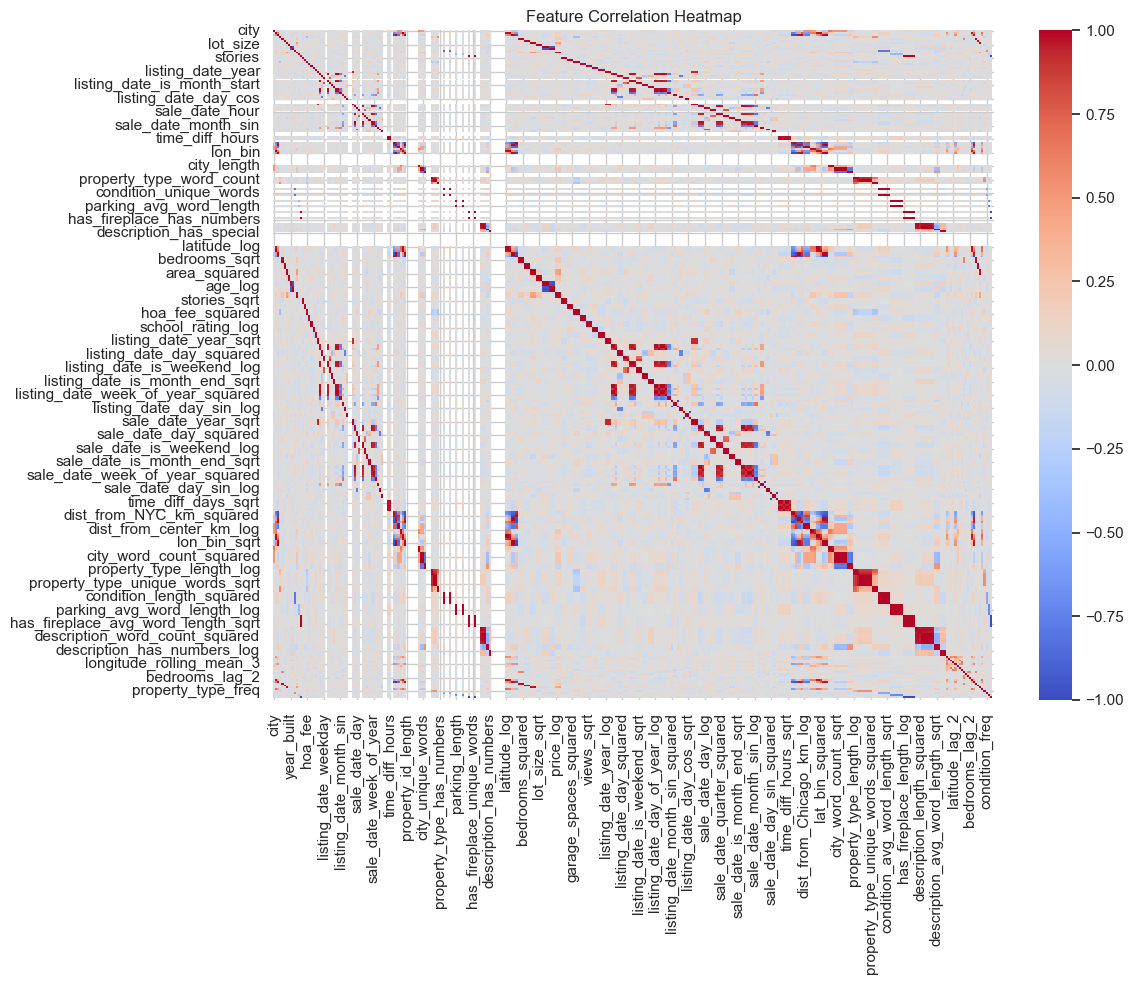

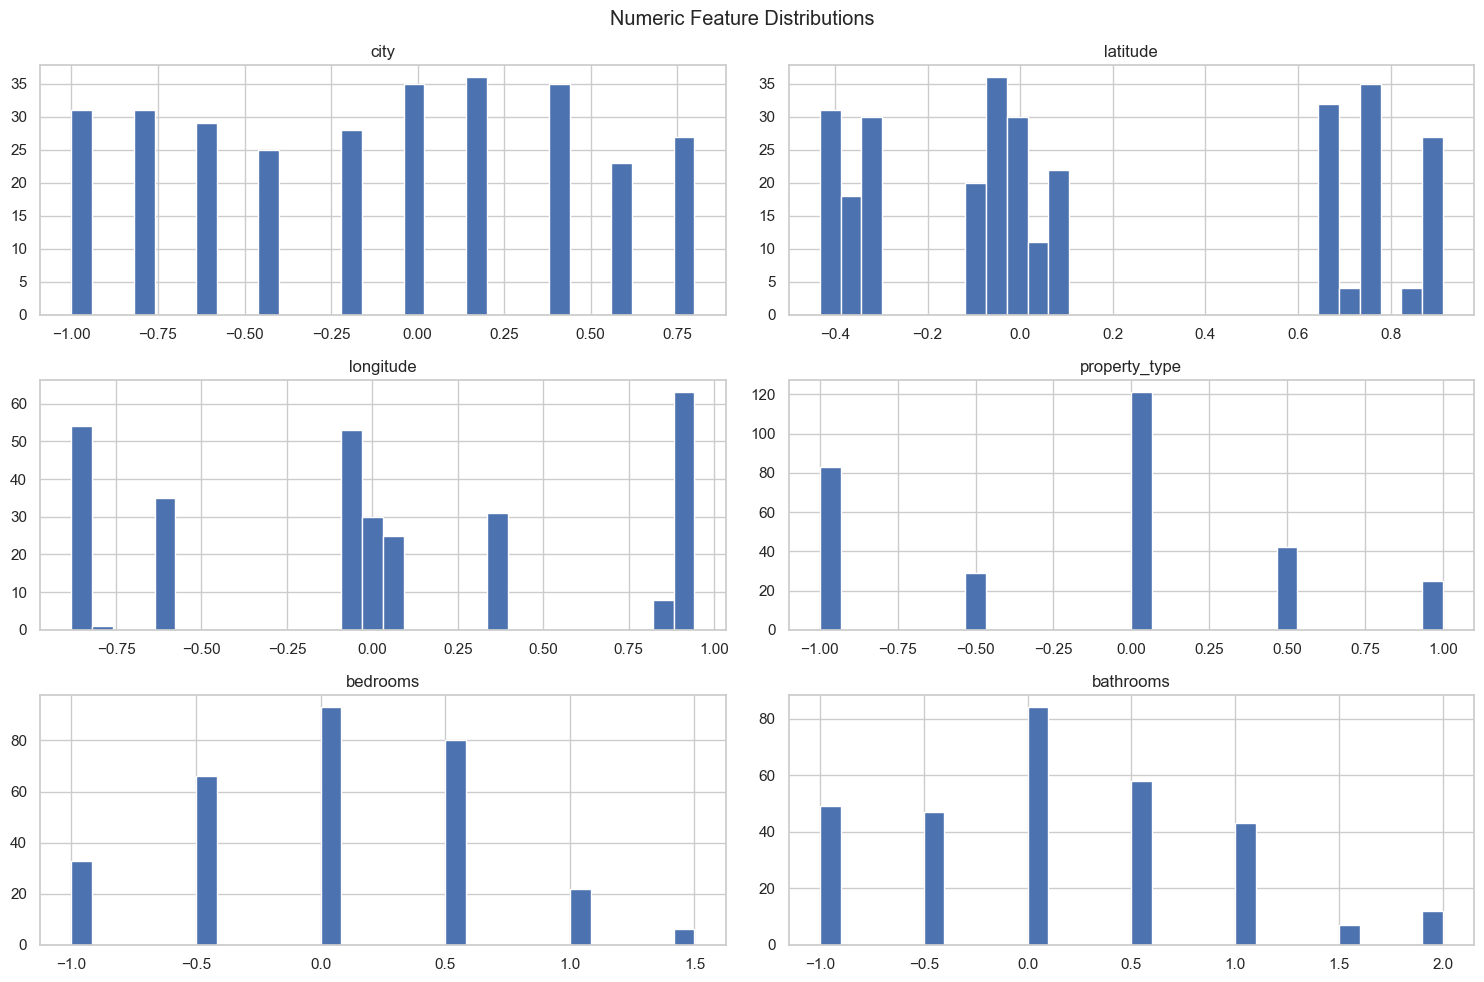

In [42]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# Distribution plots
df[num_cols[:6]].hist(figsize=(15,10), bins=30)
plt.suptitle("Numeric Feature Distributions")
plt.tight_layout()
plt.show()

# Step 17: Save Preprocessed Data

In [43]:
df.to_csv('cleaned_data.csv', index=False)
print(f"\nPreprocessing complete!")
print(f" Final shape: {df.shape}")
print(f" Original features: {df_original.shape[1]}")
print(f" Final features: {df.shape[1]}")
print(f" Features added: {df.shape[1] - df_original.shape[1]}")


Preprocessing complete!
 Final shape: (300, 365)
 Original features: 26
 Final features: 365
 Features added: 339
